Name: Batyr Kenzheakhmetov

ID: 000801267

Honor code: I have neither given nor received unauthorized aid in completing this work, nor have I presented someone else’s work as my own.

DATA: https://drive.google.com/drive/folders/1j2AtBgq__OuXMlFoW5-b0O4nKRePjhR2?usp=sharing

In [114]:
import numpy as np
import keras

# Load the VGG16 model pre-trained on ImageNet dataset
# Exclude the fully connected layers (top layers) since we might have different classes
# Set the input shape to (300, 500, 3), indicating an image size of 180x180 pixels with 3 color channels (RGB)
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",  # Using pre-trained weights on ImageNet
    include_top=False,   # Exclude the fully connected layers
    input_shape=(300, 500, 3)  # Specify input shape
)

In [108]:
# Mount Google Drive to access files stored in Google Drive
from google.colab import drive
drive.mount('/content/drive')
import os

base_dir = '/content/drive/MyDrive/FPD_BC1_BATYR'

train_dir = os.path.join(base_dir, 'train')         # Directory containing training data
vali_dir = os.path.join(base_dir, 'validation')     # Directory containing validation data
test_dir = os.path.join(base_dir, 'test')           # Directory containing test data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
from keras.utils import image_dataset_from_directory

# Create a training dataset from images in the 'train_dir' directory
# Specify the image size as (300, 500) and batch size as 8
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(300, 500),
    batch_size=16)

# Create a validation dataset from images in the 'vali_dir' directory
validation_dataset = image_dataset_from_directory(
    vali_dir,
    image_size=(300, 500),
    batch_size=4)

# Create a test dataset from images in the 'test_dir' directory
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(300, 500),
    batch_size=4,
    shuffle=True)

Found 320 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


In [119]:
from keras import models
from keras import layers
from keras import regularizers

# Instantiating the VGG16 convolutional base with pre-trained weights from ImageNet
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# Freezing the weights of the convolutional base to prevent them from being updated during training
conv_base.trainable = False

In [120]:
# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Define the input shape for the model
inputs = keras.Input(shape=(300, 500, 3))
x = data_augmentation(inputs)                                         # Apply data augmentation to the input data
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)                                                      # Pass the preprocessed input data through the convolutional base
x = layers.Flatten()(x)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01))(x)    # Add a dense layer with 128 units and L2 regularization
outputs = layers.Dense(1, activation="sigmoid")(x)                    # Add a dense output layer with a single unit and sigmoid activation for binary classification
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",                             # Compile the model with binary cross-entropy loss, RMSprop optimizer, and accuracy metric
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 300, 500, 3)]     0         
                                                                 
 sequential_21 (Sequential)  (None, 300, 500, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 300, 500, 3)       0         
 1 (SlicingOpLambda)                                             
                                                                 
 tf.nn.bias_add_21 (TFOpLam  (None, 300, 500, 3)       0         
 bda)                                                            
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_21 (Flatten)        (None, 69120)             0  

In [122]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/HW7_FP.h5", # legacy format
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
20/20 [==============================] - 12s 584ms/step - loss: 169.8061 - accuracy: 0.6531 - val_loss: 146.5391 - val_accuracy: 0.6500
Epoch 2/20
20/20 [==============================] - 7s 322ms/step - loss: 35.3826 - accuracy: 0.8125 - val_loss: 59.7454 - val_accuracy: 0.7000
Epoch 3/20
20/20 [==============================] - 7s 290ms/step - loss: 47.9300 - accuracy: 0.7969 - val_loss: 30.7151 - val_accuracy: 0.8000
Epoch 4/20
20/20 [==============================] - 7s 298ms/step - loss: 28.2031 - accuracy: 0.8781 - val_loss: 9.4728 - val_accuracy: 0.9250
Epoch 5/20
20/20 [==============================] - 6s 278ms/step - loss: 20.3747 - accuracy: 0.8906 - val_loss: 17.2553 - val_accuracy: 0.8750
Epoch 6/20
20/20 [==============================] - 6s 265ms/step - loss: 13.4660 - accuracy: 0.9219 - val_loss: 9.7223 - val_accuracy: 0.9250
Epoch 7/20
20/20 [==============================] - 8s 384ms/step - loss: 13.9142 - accuracy: 0.8906 - val_loss: 4.6236 - val_accuracy:

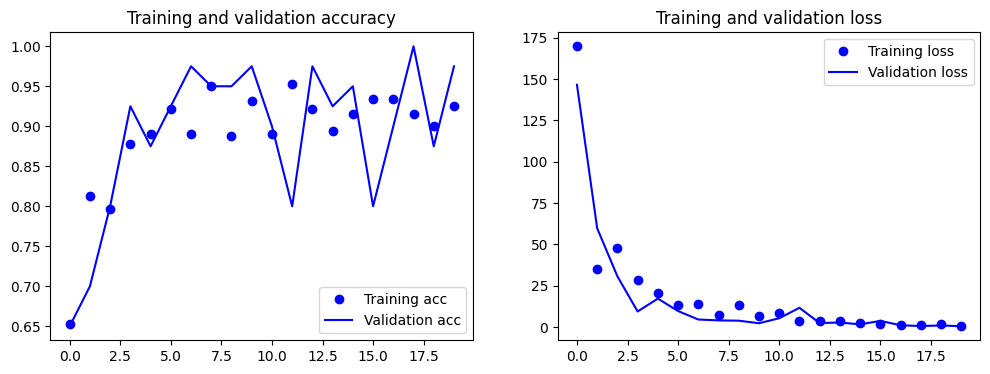

In [123]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)

ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.set_title('Training and validation accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()

plt.show()

In [124]:
loss, acc = model.evaluate(test_dataset)
print(f"FE2 model, accuracy: {100*acc :5.2f}%")

10/10 [==============================] - 1s 81ms/step - loss: 0.5080 - accuracy: 1.0000
FE2 model, accuracy: 100.00%



Conclusion and Analysis:

Overview of the Work:
My project involves identifying whose fingerprints belong to whom using machine learning techniques.
I utilized a convolutional neural network (CNN) architecture with transfer learning using the VGG16 model pre-trained on the ImageNet dataset.
Key components of my code include data loading using image_dataset_from_directory, model building, training, evaluation, and visualization of training/validation metrics.

Choice of Optimizer, Loss Function, and Metrics:
Optimizer ('rmsprop'): I chose the RMSprop optimizer for training your model. RMSprop is an adaptive learning rate optimization algorithm that adjusts the learning rate during training, which can help converge faster and potentially reach a better solution.

Loss Function ('binary_crossentropy'): Since my task involves binary classification (determining whose fingerprints belong to whom), binary cross-entropy loss is a suitable choice. It measures the difference between predicted probabilities and actual labels, penalizing incorrect predictions more heavily.
Metrics (['accuracy']): You selected accuracy as the metric to evaluate my model's performance. Accuracy measures the proportion of correctly classified samples, which is a relevant metric for binary classification tasks.

Data Augmentation and Preprocessing:
Data Augmentation: I applied data augmentation using horizontal flipping, rotation, and zooming to increase the variability of your training data. This helps the model generalize better to unseen data and reduces the risk of overfitting.

Preprocessing: Before passing the data through the VGG16 model, I preprocessed it using the preprocess_input function from keras.applications.vgg16. This function preprocesses the input data according to the requirements of the VGG16 model, which includes mean centering and scaling.

Model Architecture:
Input Layer: I defined an input layer with a shape of (300, 500, 3), indicating images of size 300x500 pixels with 3 color channels (RGB).
Data Augmentation Integration: Data augmentation was applied directly to the input data before passing it through the model. This allows the model to learn from augmented versions of the original images, enhancing its robustness.
Flatten and Dense Layers: After passing the preprocessed input data through the VGG16 convolutional base, I flattened the output and added a dense layer with 128 units. Regularization was applied to this layer using L2 regularization with a coefficient of 0.01, which helps prevent overfitting by penalizing large weights.

Early Stopping at 20 Epochs:
Reasoning I decided to stop training at 20 epochs, likely to prevent overfitting and save computational resources. Overfitting can occur when the model learns noise and details specific to the training data, leading to poor generalization to new data. By stopping training early, I avoid excessive exposure to the training data, reducing the risk of overfitting.
Evaluation: After training for 20 epochs, I evaluated the model's performance on the validation dataset to ensure it didn't degrade significantly. This approach allows I to strike a balance between model performance and computational efficiency.

In summary, my approach demonstrates thoughtful consideration of model architecture, optimization, and training strategies for the fingerprint identification task. By leveraging transfer learning, data augmentation, appropriate loss functions, and regularization techniques, I've constructed a robust and efficient model for identifying fingerprints. Additionally, the decision to stop training early at 20 epochs reflects a prudent approach to balancing model performance and computational resources.